# はじめに

2つの時系列データを比較し，それらの間の遠さを知る方法として，[Dynamic Time Warping (DTW)](https://ksknw.hatenablog.com/entry/2017/03/26/234048)があります．
DTWは，2つの時系列データの各フレームを対応付けることによって定義されます．
このとき，対応付けは「対応付けられたフレーム間の距離が最小になる」ように定められます．
この操作(実際には動的計画法)は微分可能ではない[^1]ため，DTWを例えば深層学習モデルの目的関数として用いると最適化が安定しないなどの問題がありました．

[soft-DTW (Marco Cuturi and Mathieu Blondel, ICML217)](https://arxiv.org/abs/1703.01541) はDTWを微分可能な形に拡張するものです．
実装としては非常に簡単で，DTWの動的計画法の中で出てくるmin関数をsoft-min関数に置き換えるだけで実現可能です．
ここでは，soft-DTWをPyTorchによって実装し，これを目的関数とした最適化問題の例として，台風の軌跡のbarycenterを求める問題を解くことで，DTWとsoft-DTWを比較し，soft-DTWによってより自然な(?)barycenterが得られることを示します．

ここでは，PyTorchを用いて実装を行いますが，適当な実装なので，遅いです．
例えば，[tslearn](https://tslearn.readthedocs.io/en/stable/index.html)の実装を用いることでより高速に(かつバグの可能性が少ない)結果を得ることができます．

[^1]: 正確には，対応付けをfixだとしたときの勾配のみが求まる．


# Dynamic Time Warping

DTWについては過去に実装したものがあるので，詳しくはそちらを参照ください．
DTWでは2つの時系列データ$X = x_1, \dots x_n, Y=y_1, \dots, y_m$が与えられたとき，これらの間の距離を以下のように定義します．

$$
DTW(X, Y) \equiv \min_{A\in \mathcal A} \big<A, \Delta(X, Y) \big >
$$

ここで，$\big< \big>$は行列の内積(要素ごとに積をとって和)を表し，$\Delta(X,Y) \in \mathbb R^{n \times m}$は各要素$\Delta_{ij}$がフレーム間の距離$\Delta_{ij} = d(x_i, y_j)$を表すコスト行列です．
$A$はアライメント行列と呼ばれる，どのフレーム間を対応付けるのかを表す行列であり，$A_{ij} \in \{0,1\}$です．
$A_{ij}=1$は$x_i$と$y_j$を対応付けることを意味します．
また，$\mathcal A$はアライメント行列の制約条件を満たす行列の集合を表します．

例として，以下の2つの時系列データ入力として，適当なsin波に対してDTWを適用します．

In [1]:
import numpy as np
import pylab as plt
import pandas as pd
import matplotlib.gridspec as gridspec
import torch

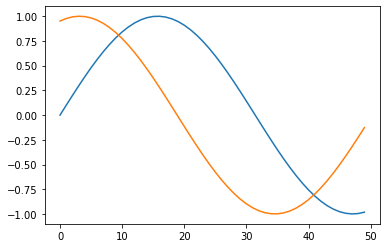

In [2]:
T = 50
t = .4

X = np.sin(np.array(range(T))/10)
Y = np.sin((np.array(range(T))/10 + t*np.pi))

plt.plot(X)
plt.plot(Y)
plt.show()

DTWは以下のような動的計画法によって得ることができます．
ここでmは累積誤差を表しています．
DTWにおける動的計画法については，[こちら](http://sinhrks.hatenablog.com/entry/2014/11/14/232603)のブログのアニメーションがわかりやすいです．

In [3]:
X,Y = torch.FloatTensor(X), torch.FloatTensor(Y)

Delta = (X[:,None] - Y[None, :])**2

def dtw(Delta):
    S, T = Delta.shape

    m = torch.zeros(S, T)
    m[0,0] = Delta[0,0]
    for i in range(1,S):
        m[i,0] = m[i-1,0] + Delta[i,0]
    for j in range(1,T):
        m[0,j] = m[0, j-1] + Delta[0,j]

    for i in range(1,S):
        for j in range(1,T):
            m[i,j] = Delta[i,j] + min(m[i-1,j], m[i,j-1], m[i-1,j-1])
    return m[-1, -1]

In [4]:
dtw(Delta)

tensor(6.1637)

次に，アライメント行列を求めます．
アライメント行列は，動的計画法のminを求めている部分でargminを保存しておくことで，容易に求めることができますが，ここではDTWのコスト行列に対する勾配を利用することで，アライメント行列を求めます．
もう一度DTWの式を眺めます．

$$
\begin{aligned}
\text{dtw}(X, Y) & \equiv \min_{A\in \mathcal A} \big<A, \Delta(X, Y) \big > \\
&= \big<A^*, \Delta(X, Y) \big >
\end{aligned}
$$

ここで，$A^*$は最小値を実現するアライメント行列としました．
DTWの値は最適なアライメント行列$A^*$とコスト行列$\Delta(X,Y)$の内積です．
このため，$A^*$のij成分は以下のように求めることができます．

$$
A^*_{ij} = \frac{\partial \text{dtw}(X, Y)}{\partial \Delta(X,Y)_{ij}} 
$$

動的計画法の勾配を明に実装するのはちょっと面倒ですが，autogradを使うと以下のように容易に求めることができます．

In [5]:
Delta.requires_grad = True
dtw(Delta).backward()
A = Delta.grad.detach().numpy()

それっぽい絵を描くと以下です．

In [6]:
def plot_path(A, X, Y, D):
    plt.figure(figsize=(5,5))
    gs = gridspec.GridSpec(2, 2,
                       width_ratios=[1,5],
                       height_ratios=[5,1]
                       )
    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1])
    ax4 = plt.subplot(gs[3])

    ax2.get_xaxis().set_ticks([])
    ax2.get_yaxis().set_ticks([])    
    ax2.pcolor(A)
    
    ax4.plot(X)
    ax4.set_xlabel("$X$")
    ax1.invert_xaxis()
    ax1.plot(Y, range(len(Y)), c="C1")
    ax1.set_ylabel("$Y$")

    ax2.set_xlim(0, len(X))
    ax2.set_ylim(0, len(Y))
    plt.show()

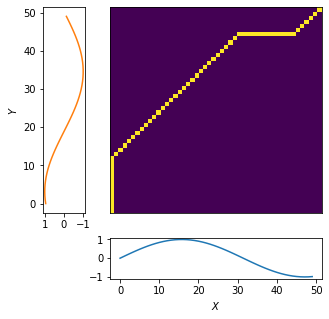

In [7]:
plot_path(A, X, Y, Delta.detach().numpy())

対応付けられたフレーム同士を線でつなぐとこのように1対1に対応付けられていることがわかります．

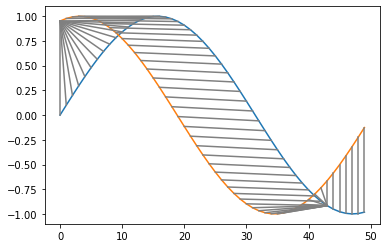

In [8]:
plt.plot(X)
plt.plot(Y)

for i,j in np.array(np.meshgrid(np.arange(len(X)), np.arange(len(Y)))).reshape(2, -1).T:
    plt.plot([i,j], [X[i], Y[j]], alpha=A[i,j], c="gray")

DTWの勾配を利用することでアライメント行列を求めることができました．

次にDTWを目的関数とした以下の最適化問題を勾配法によって解くことを考えます．

$$
\min_\theta \text{dtw}(X,Y_\theta)
$$

このような問題は，例えば，RNNから出力される時系列データ$Y_\theta$に関して，$\theta$，つまり，RNNのパラメータを最適化したい場合などがあります．

DTWのYに関する勾配は

$$
\begin{aligned}
\frac{\partial \text{dtw}(X,Y)}{\partial Y_j} & = \sum_{i} \frac{\partial \text{dtw}(X, Y)}{\partial \Delta(X,Y)_{ij}} \frac{\partial \Delta(X,Y)_{ij}}{\partial Y_j} \\
&= \sum_{i} A_{ij}^* \frac{\partial \Delta(X,Y)_{ij}}{\partial Y_j} 
\end{aligned}
$$


として求めることができます．
このように，DTWを目的関数としても勾配を求めることはできるため，勾配を用いてYを徐々に更新することは可能です．
しかし，勾配の形を見てもわかるとおり，この勾配は，$Y$が変化してもアライメント行列$A_{ij}^*$は変化しないことを仮定しています．
しかし，実際には時系列データ$Y$を更新していくと，あるとき，アライメント行列$A_{ij}^*$は切り替わるような動きをします．
このような挙動は最適化の性能を落としてしまいます．

# Softminとmin


soft-DTWの説明の前に，softmin関数を導入します．
これは以下のように定義することができます．

$$
\text{min}^\gamma(x_1, \dots, x_n) \equiv \begin{cases} -\gamma \log \sum_{i=1}^n \exp (-x_i / \gamma) & (\gamma>0)\\
\min (x_1, \dots, x_n) &(\gamma=0)
\end{cases}
$$

softmin関数はminを滑らかにしたものであり，あとでみるように$\gamma$を0に近づけていくと，minに近づきます．


余談:
ニューラルネットワークをやっているひとはsoftmaxを知っていると思います．
名前がややこしくて混乱しますが，NNのsoftmax関数は0~1の出力で，自分が(単独で)最大であれば1に近づく関数という意味で，soft-argmax関数というほうが正しいでしょう．これに対して，ここで定義したsoftminはminを滑らかにしたものという意味で正しくsoftmin関数です．


softmin関数の挙動について，詳しく見てみます．
入力$x_1, x_2$が与えられたとき，minの等高線，および，softminの出力の等高線は以下のグラフのようにかけます．

In [9]:
def softmin(a, gamma, dim=0):
    return -gamma * torch.logsumexp(-a / gamma, dim=0)

minの等高線

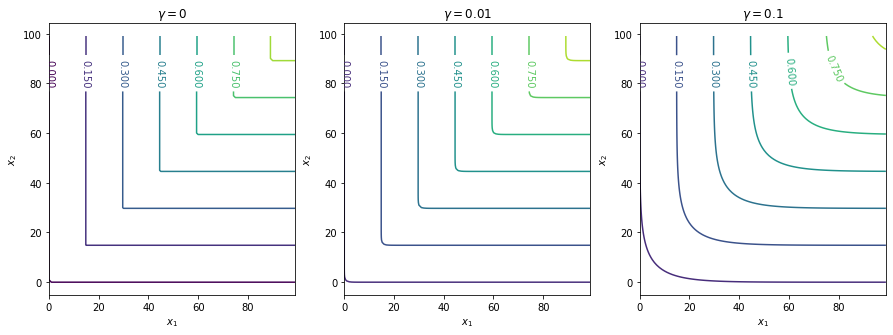

In [10]:
grid = torch.stack(torch.meshgrid( torch.linspace(0,1, 100), torch.linspace(0,1,100))).reshape(2, -1)

fig, ax = plt.subplots(1,3,figsize=(15,5))
for ax_i in ax:
    ax_i.axis("equal")
    ax_i.set_xlabel("$x_1$")
    ax_i.set_ylabel("$x_2$")
    
min_values = torch.min(grid, dim=0)[0]
cs = ax[0].contour(min_values.numpy().reshape(100,100))
ax[0].clabel(cs, inline=1, fontsize=10)
ax[0].set_title("$\gamma=0$")

softmin_values = softmin(grid, 0.01, dim=0)
cs = ax[1].contour(softmin_values.numpy().reshape(100,100))
ax[1].clabel(cs, inline=1, fontsize=10)
ax[1].set_title("$\gamma=0.01$")

softmin_values = softmin(grid, 0.1, dim=0)
cs = ax[2].contour(softmin_values.numpy().reshape(100,100))
ax[2].clabel(cs, inline=1, fontsize=10)
ax[2].set_title("$\gamma=0.1$")

plt.show()

図より，minは直角な等高線をしているのに対して，softminでは$\gamma$を大きくするにつれて徐々に角が丸まっていくのがわかります．
これらの関数の勾配は等高線に対して直角方向に対応します．
min関数では勾配はどちらの値が小さいかに対応して，(1,0)もしくは(0,1)になります．
これに対して，softminでは入力の値が近いときには，斜め方向に勾配をもつことがわかります．

# Soft-DTW

DTWでは勾配の計算に，そのときの最適なアライメント行列$A^*$のみを考慮し，他のアライメント行列の可能性を一切考慮していませんでした．
このため，時系列データ$Y$が少し変化した際に，$A^*$が急激に変化することがあり，これが最適化の邪魔をしてしまうことがありました．

Soft-DTWは，最適なアライメント行列だけを考えるのではなく，すべてのアライメント行列を重み付きで考慮します．
Soft-DTWは以下のように定義されます．

$$
\text{dtw}^\gamma(X, Y) \equiv \text{min}_{A\in \mathcal A}^\gamma  \big<A, \Delta(X, Y) \big >
$$

Soft-DTWはDTWと同様に動的計画法によって解くことができます(minをsoftminに置き換えるだけです)．

In [11]:
def softdtw(Delta, gamma):
    S, T = Delta.shape

    m = torch.zeros(S, T)
    m[0,0] = Delta[0,0]
    for i in range(1,S):
        m[i,0] = m[i-1,0] + Delta[i,0]
    for j in range(1,T):
        m[0,j] = m[0, j-1] + Delta[0,j]

    for i in range(1,S):
        for j in range(1,T):
            m[i,j] = Delta[i,j] + softmin(torch.stack([m[i-1,j], m[i,j-1], m[i-1,j-1]]), gamma)
    return m[-1, -1]

In [12]:
softdtw(Delta, 0.01)

tensor(5.7458, grad_fn=<SelectBackward>)

Soft-DTWのコスト行列に関する勾配は以下のようになります．

$$
\frac{\partial \text{dtw}^\gamma(X, Y)}{\partial \Delta(X,Y)_{ij}} = \frac{1}{Z}\sum_{A\in \mathcal A} \exp \big(- \big< A, \Delta \big> /\gamma \big) A_{ij}
$$

ここで，$Z = \sum_{A\in \mathcal A} \exp \big(- \big< A, \Delta \big> /\gamma \big)$です．
この右辺をよく見ると，Aの確率分布$p(A)$をGibbs分布$p(A) =  \frac{1}{Z}\sum_{A\in \mathcal A} \exp \big(- \big< A, \Delta \big> /\gamma \big)$としたときの，アライメント行列の期待値$\mathbb E_\gamma [A]$になっていることがわかります．

論文の中では明なbackwardルールが記載されていますが，これもautogradを使えば，特に何も気にせず勾配を得ることができます(速度には差があるかもしれません)．

In [13]:
Delta.grad.zero_()
softdtw(Delta, 0.01).backward()
A = Delta.grad.detach().numpy()

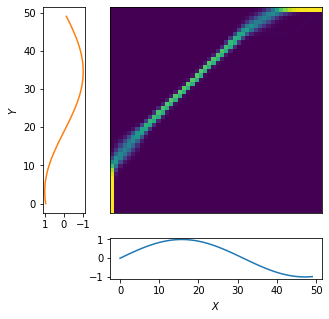

In [14]:
plot_path(A, X, Y, Delta.detach().numpy())

DTWのときとは異なり，アライメント行列がぼやっとしていることがわかります．これは最適な1つのアライメント行列だけでなく，コストがあまりかわらない別のアライメント行列も考慮されていることに対応します．

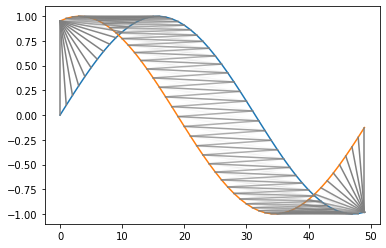

In [15]:
plt.plot(X)
plt.plot(Y)

for i,j in np.array(np.meshgrid(np.arange(len(X)), np.arange(len(Y)))).reshape(2, -1).T:
    plt.plot([i,j], [X[i], Y[j]], alpha=A[i,j], c="gray")

# 最適化問題のロス関数として用いたときの比較

では実際に，最適化のロス関数としてDTWおよびsoft-DTWを用いたときの挙動を確認します．
ここでは2017年から2020年までに日本に上陸した台風の軌跡データから，平均的な軌跡(barycenter)を求める問題を考えます．
データは[気象庁から公開されているもの](https://www.data.jma.go.jp/fcd/yoho/typhoon/position_table/index.html)を用いました．

DTW barycenter $Y$を求める最適化は以下のように書くことができます．

$$
\min_Y \sum_{n=1}^N \text{dtw}(X_n,Y)
$$

これは$N$個の時系列データ$X_1, \dots, X_N$が与えられたとき，これらとのDTW距離が最小になる$Y$を求める問題です．
soft-DTWを用いる場合も同様に定義することができます．
一般にDTW barycenterは[DBA]()などの方法が用いられることが多いですが，ここでは，勾配法によってbarycenter $Y$を求めることにします．

とりあえずデータをプロットします

In [16]:
from glob import glob
from mpl_toolkits.basemap import Basemap

In [17]:
traces = []
for file in sorted(glob("./data/table*")):
    data = pd.read_csv(file, encoding="shift_jis")
    for ind in data["台風番号"].unique():
        temp = data[data["台風番号"] == ind]
        if sum(temp["上陸"]==1) > 0:
            traces.append(torch.FloatTensor(temp[["経度", "緯度"]].values))

In [18]:
def plot(traces, Y=None):
    m = Basemap(llcrnrlon=100.,llcrnrlat=10.,urcrnrlon=170.,urcrnrlat=60.,
                rsphere=(6378137.00,6356752.3142),
                resolution='h',projection='merc')
    m.fillcontinents()
    
    for tr in traces:
        tr_numpy = tr.detach().numpy()
        x,y = m(tr_numpy[:, 0], tr_numpy[:, 1])
        plt.plot(x,y,  marker="", lw=1, ls="-", c="gray", alpha=0.4)
        
    if Y is not None:
        Y_numpy = Y.detach().numpy()
        x,y = m(Y_numpy[:, 0], Y_numpy[:, 1])
        plt.plot(x,y,  marker="", lw=1, ls="-", c="C1")

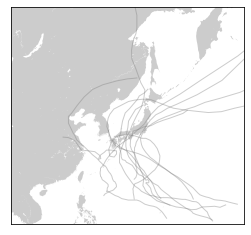

In [19]:
plot(traces)

barycenter $Y$の初期値として，ここでは，データとして与えられた軌跡の中から最もbarycenterに近いもの，つまり，他の時系列データとのDTWの合計が小さいものを選びます．

In [20]:
from itertools import combinations

In [21]:
dists = np.zeros((len(traces), len(traces)))

for i in range(len(traces)-1):
    for j in range(i+1, len(traces)):
        Delta = ((traces[i][:,None] - traces[j][None, :])**2).sum(axis=-1)
        dists[i,j] = dtw(Delta)

In [22]:
np.argmin(np.sum(dists + dists.T, axis=0))

8

In [23]:
Y = traces[8].clone()
Y = torch.FloatTensor(Y)
Y.requires_grad = True

では，実際に勾配法によって$Y$を更新してみます．

## DTW ($\gamma=0$)

In [24]:
from torch.optim import Adam

optimizer = Adam([Y], lr=1)

In [25]:
from tqdm.notebook import tqdm

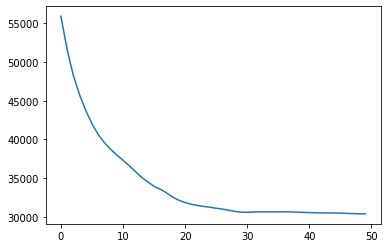

In [26]:
hist = []

epoch = 50

for e in tqdm(range(epoch)):
    loss = 0
    for X in traces:
        Delta = ((X[:,None] - Y[None, :])**2).sum(dim=-1)
        loss += dtw(Delta)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    hist.append(loss.detach().numpy())
    
plt.plot(hist)

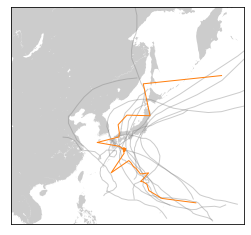

In [27]:
plot(traces, Y)

ロスは収束してしますが，求まった軌跡はガタガタで平均的な台風の軌跡とは言えなさそうです．
(そもそもDTW barycenterのみた目はあまり平均的な軌跡っぽくならないというのもありますが)

## soft-DTW ($\gamma=1$)

次にsoft-DTWを用いてbarycenterを求めてみます．ロスがsoft-DTWになっていること以外は上と同じです．

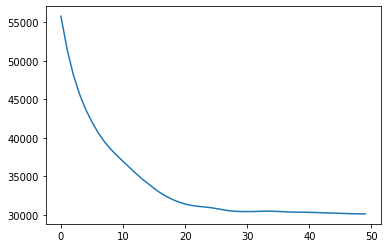

In [28]:
Y_1 = traces[8].clone()
Y_1.requires_grad = True

optimizer = Adam([Y_1], lr=1)

hist = []

for e in tqdm(range(epoch)):
    loss = 0
    for X in traces:
        Delta = ((X[:,None] - Y_1[None, :])**2).sum(dim=-1)
        loss += softdtw(Delta, gamma=1)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    hist.append(loss.detach().numpy())
plt.plot(hist)

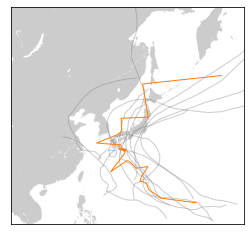

In [29]:
plot(traces, Y_1)

期待と異なり，DTWを用いた場合とあまり変わらない結果になりました．

## soft-DTW ($\gamma=100$)
$\gamma=1$ではDTWを用いた場合とあまりかわらないように見えたので，次は$\gamma=100$にしてbarycenterを求めてみます．

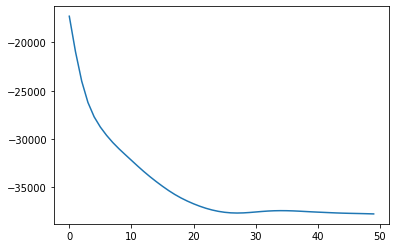

In [30]:
Y_100 = traces[8].clone()
Y_100.requires_grad = True

optimizer = Adam([Y_100], lr=1)

epoch = 50
hist = []

for e in tqdm(range(epoch)):
    loss = 0
    for X in traces:
        Delta = ((X[:,None] - Y_100[None, :])**2).sum(dim=-1)
        loss += softdtw(Delta, gamma=100)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    hist.append(loss.detach().numpy())
plt.plot(hist)

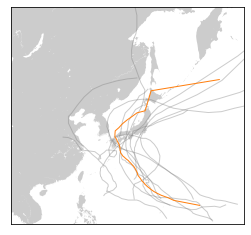

In [31]:
plot(traces, Y_100)

それらしい(?)結果が得られました．
並べて描くと以下です．

Text(0.5, 1.0, 'Soft DTW ($\\gamma=100$)')

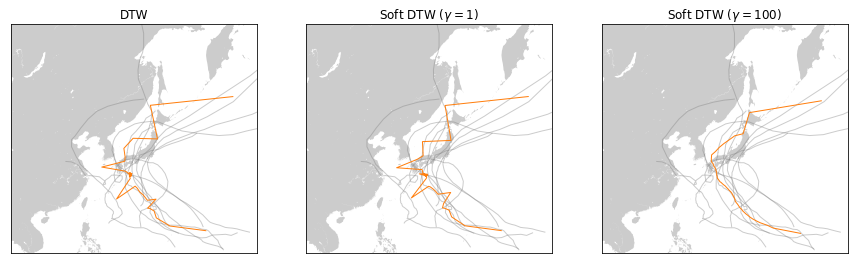

In [32]:
plt.figure(figsize=(15,5))

plt.subplot(131)
plot(traces, Y)
plt.title("DTW")

plt.subplot(132)
plot(traces, Y_1)
plt.title("Soft-DTW ($\gamma=1$)")

plt.subplot(133)
plot(traces, Y_100)
plt.title("Soft-DTW ($\gamma=100$)")

soft-DTWの$\gamma$を大きな値に設定することで，それらしいbarycenterを得ることができました．
一方で，これが，微分可能になったことで最適化がうまくできたことが原因かと言われると微妙です．

DTW barycenterはそもそもギザギザの形状を取りやすい性質があります．
例えば，西を大きく回って東に抜ける軌跡と，東側を抜けていく軌跡があるとき，平均的な軌跡としては，これらの真ん中を通過するような軌跡を期待しますが，DTWの合計を最も小さくしようとすると，例えば多くの点は東側を抜ける軌跡と一致させ，西に数点の点を取るギザギザの軌跡が選択されることがあります．これは，西側にある数点を，西を大きく回る軌跡の多くの点と対応付けることで，DTWの値を小さくすることができるためです．
Soft-DTWの$\gamma$を大きくすると，ある1つのアライメント行列だけでなく，他のアライメント行列もロスとして考慮されます．このとき，西の数点以外の点と，西側を回る軌跡が対応付けられるため，結果として，barycenterを期待するようなものへと変化させる勾配が生まれている気がします．


# まとめ

DTWを微分可能な形に拡張したsoft-DTWの実装を行いました．
DTWとの違いはmin関数の代わりにsoftmin関数を用いるところで，実装はPyTorchの自動微分を用いることで容易に可能でした．
台風の軌跡データを用いてbarycenterを求め，soft-DTWの$\gamma$の値を大きくすることで，それらしいbarycenterが得られることを確認しました．
一方で，微分可能になったことの恩恵を受けている気はあまりしませんでした．barycenter以外の別の最適化問題を解かせてみると，大きな違いがあるかもしれません．
また，普通，DTW barycenterを求めるときは普通DBA(今のbarycenterと他の系列をアライメントして対応付けられた点の平均でbarycenterを更新)を用います．このアライメントと平均を交互に求める方法はsoft-DTWであっても利用可能です．
この意味でも別の最適化問題で挙動を見てみることは意味があると思います．

## 参考

- [https://ksknw.hatenablog.com/entry/2017/03/26/234048:title]
- [https://arxiv.org/abs/1703.01541:title]
- [https://tslearn.readthedocs.io/en/stable/index.html:title]
- [https://www.data.jma.go.jp/fcd/yoho/typhoon/position_table/index.html:title]
